In [ ]:
import os
import shutil
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math
from torchsummary import summary
import matplotlib.pyplot as plt
import torch.nn.functional as F
import time
import math
from scipy import stats

In [ ]:
def lstm_data_transform(x_data, y_data, num_steps=75):
    """ Changes data to the format for LSTM training 
for sliding window approach """
    # Prepare the list for the transformed data
    X, y = list(), list()
    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps
        # if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break
        # Get a sequence of data for x
        seq_X = x_data[i:end_ix]
        # Get only the mean of the sequence labels and rounding the value for label of the sequency
        mean_arr_y= y_data[i:end_ix]
        # y_mean_label=round(np.average(mean_arr_y))
        # seq_y = y_mean_label
        # print(y_mean_label)
        # Finding the most repeatitive label in the list of labels in the given sequence by using mode function
        y_mean_label = stats.mode(mean_arr_y)
        y_label = y_mean_label[0][0][0]
        seq_y = y_label

        ## Scale labels between 0 to 3 ################################
        seq_y=seq_y-1.0

        # Append the list with sequencies
        X.append(seq_X)
        y.append(seq_y)
    # Make final arrays
    x_array = np.array(X)
    y_array = np.array(y)
    x=torch.from_numpy(x_array)
    y=torch.from_numpy(y_array)
    return x, y

In [ ]:
## Splitting Data into Train, Test and Validation:
Train_split=0.6
Test_split=0.2
Validation_split=0.2

In [ ]:
with open('/content/drive/MyDrive/MultiPain/GRU/Data/071709_w_23.csv', 'r') as f:
  xy_pain = np.loadtxt(f, delimiter=",",dtype=np.float32,skiprows=1)

x_p=(xy_pain[:1,2:-2])
print(x_p.shape)
y_p=(xy_pain[:(math.floor(Train_split*len(xy_pain))),[-1]])

(1, 34)


In [ ]:
class PainDataset_Train(Dataset):
    """ Pain dataset."""

    # Initialize your data, download, etc.
    def __init__(self):
        with open('/content/drive/MyDrive/MultiPain/GRU/Data/071709_w_23.csv', 'r') as f:
          xy_pain = np.loadtxt(f, delimiter=",",dtype=np.float32,skiprows=1)
        
        # x_p=(xy_pain[:(math.floor(Train_split*len(xy_pain))),2:-19])
        # y_p=(xy_pain[:(math.floor(Train_split*len(xy_pain))),[-1]])

        x_p=(xy_pain[:(math.floor(Train_split*len(xy_pain))),2:-2])
        y_p=(xy_pain[:(math.floor(Train_split*len(xy_pain))),[-1]])
       
        x_sequences,y_sequences=lstm_data_transform(x_p,y_p)
        
        self.x_data = x_sequences
        self.y_data = y_sequences
                
        # print(y_sequences)

        self.len = x_sequences.shape[0]
        
    def __getitem__(self, index):
        return self.x_data[index], torch.tensor(self.y_data[index])

    def __len__(self):
        return self.len

In [ ]:
# test_dataset = PainDataset_Train()
# teest_loader = DataLoader(dataset=test_dataset,batch_size=1,shuffle=False)

In [ ]:
class PainDataset_Validation(Dataset):
    """ Pain dataset."""

    # Initialize your data, download, etc.
    def __init__(self):
        with open('/content/drive/MyDrive/MultiPain/GRU/Data/071709_w_23.csv', 'r') as f:
          xy_pain = np.loadtxt(f, delimiter=",",dtype=np.float32,skiprows=1)
        x_p=(xy_pain[(math.floor(Train_split*len(xy_pain))):(math.floor((Train_split+Validation_split)*len(xy_pain))),2:-2])
        y_p=(xy_pain[(math.floor(Train_split*len(xy_pain))):(math.floor((Train_split+Validation_split)*len(xy_pain))),[-1]])

        x_sequences,y_sequences=lstm_data_transform(x_p,y_p)

        self.x_data = x_sequences
        self.y_data = y_sequences

        self.len = x_sequences.shape[0]
        

    def __getitem__(self, index):
        return self.x_data[index], torch.tensor(self.y_data[index])

    def __len__(self):
        return self.len

In [ ]:
class PainDataset_Test(Dataset):
    """ Pain dataset."""

    # Initialize your data, download, etc.
    def __init__(self):
        with open('/content/drive/MyDrive/MultiPain/GRU/Data/071709_w_23.csv', 'r') as f:
          xy_pain = np.loadtxt(f, delimiter=",",dtype=np.float32,skiprows=1)
        
        x_p=(xy_pain[(math.floor((Train_split+Validation_split)*len(xy_pain))):len(xy_pain),2:-2])
        y_p=(xy_pain[(math.floor((Train_split+Validation_split)*len(xy_pain))):len(xy_pain),[-1]])
        
        x_sequences,y_sequences=lstm_data_transform(x_p,y_p)
        
        self.x_data = x_sequences
        self.y_data = y_sequences
        
        self.len = x_sequences.shape[0]
        

    def __getitem__(self, index):
        return self.x_data[index], torch.tensor(self.y_data[index])

    def __len__(self):
        return self.len

In [ ]:
# test_dataset = PainDataset_Test()
# teest_loader = DataLoader(dataset=test_dataset,batch_size=1,shuffle=False)

In [ ]:
print("Train_split: ",Train_split*100,"% Test_split :",Test_split*100,"% Validation_split :",Validation_split*100,"% ")

Train_split:  60.0 % Test_split : 20.0 % Validation_split : 20.0 % 


In [ ]:
start = time.time()

device = torch.device('cuda')

# Hyper-parameters 
# input_size = 18 AU (Both presence(1) and intensities(17) )
num_classes = 4 ## (Binary classification as pain(0) or no pain(1) )
num_epochs = 40
batch_size = 30
learning_rate = 0.001

input_size = 34
sequence_length = 75
hidden_size = 50
num_layers = 2


## PAIN DATASET

## Add dataset here

train_dataset = PainDataset_Train()
train_loader = DataLoader(dataset=train_dataset,batch_size=30,shuffle=True)

# Fully connected neural network with one hidden layer
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # -> x needs to be: (batch_size, seq, input_size)
        
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        # Can add sigmoid here itself ################################################## 
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # Set initial hidden states (and cell states for LSTM)
        h0 = torch.ones(self.num_layers, x.size(0), self.hidden_size).to(device) 
        
        # Check list sizes here to match required lengths
        # x: (n, 28, 28), h0: (2, n, 128)
        
        # Forward propagate RNN
        out, _ = self.gru(x, (h0))  
        
        # out: tensor of shape (batch_size, seq_length, hidden_size)
        # out: (n, 28, 128)
        
        # Decode the hidden state of the last time step
        out = out[:, -1, :]
        # out: (n, 128)
#         F.log_softmax(self.linear(bow_vec), dim=1)
        out = self.fc(out)
        out= F.log_softmax((out),dim=1)
        # out: (n, 2)
        return out

model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss and optimizer setting
criterion = nn.CrossEntropyLoss() ## Useful for later stage where we might have to use pain levels
# criterion = nn.NLLLoss()
# criterion = nn.BCELoss()
# criterion = nn.BCEWithLogitsLoss()
# m = nn.Sigmoid()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  
## Hinge loss try

In [ ]:
# zz=next(iter(train_loader))
# zz[0].shape

In [ ]:
# summary(model,input_size=(10,30,18))
print(model)

RNN(
  (gru): GRU(34, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=4, bias=True)
)


In [ ]:
n_total_steps = len(train_loader)
i=0

loss_count=[]
Valid_count=[]
Test_count=[]
for epoch in range(num_epochs):
    loss_value=0.0
    for i,data in enumerate(train_loader, 0):
#         print(data)
        features, labels = data

        # print('labels',labels)
#         print('features',features)
        
        features = features.reshape(-1, sequence_length, input_size).to(device)
#         print(features.shape)
        labels = labels.to(device)
        # Forward pass
        outputs = model(features)
#         print(len(labels),len(m(outputs)[0]))
#         print("sh",features.shape)
#         print('out',outputs.shape)
#         print('lab',labels.shape)
        loss = criterion(outputs, labels.long())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        i+=1
        loss_value+=loss.item()
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.6f}')
    loss_count.append(loss_value/n_total_steps)
    ## Add validation code here (End of an epoch)

    Val_dataset = PainDataset_Validation()
    Val_loader = DataLoader(dataset=Val_dataset,batch_size=10,shuffle=True)
    # Test the model on Validation data
    # In test phase, we don't need to compute gradients (for memory efficiency)
    n_total_steps_v = len(Val_loader)
    with torch.no_grad():
        n_correct_v = 0
        n_samples_v = 0
        valid_loss_value=0.0
        for i,data_v in enumerate(Val_loader, 0):
            # print(data)
            features_v, labels_v = data_v
            features_v = features_v.reshape(-1, sequence_length, input_size).to(device)
            labels_v=labels_v.to(device)
            
            outputs_v = model(features_v)
            # print(outputs)
            _, predicted_v = torch.max(outputs_v.data, 1)
            valid_loss = criterion(outputs_v, labels_v.long())
            valid_loss_value+=valid_loss.item()
            # print('predicted',predicted)
            # print('labels',labels)
            n_samples_v += labels_v.size(0)
            n_correct_v += (predicted_v == labels_v.long()).sum().item()
        # append avg val loss 
        Valid_count.append(valid_loss_value/n_total_steps_v)
        acc_val = 100.0 * n_correct_v / n_samples_v
        print(f'Accuracy of the network on Validation data for epoch {epoch+1} is : {acc_val} %')
      
    Test_dataset = PainDataset_Test()
    Test_loader = DataLoader(dataset=Test_dataset,batch_size=30,shuffle=True)
    # Test the model on Validation data
    # In test phase, we don't need to compute gradients (for memory efficiency)
    n_total_steps_t = len(Test_loader)
    with torch.no_grad():
        n_correct_t = 0
        n_samples_t = 0
        test_loss_value=0.0
        for i,data_t in enumerate(Test_loader, 0):
            # print(data)
            features_t, labels_t = data_t
            features_t = features_t.reshape(-1, sequence_length, input_size).to(device)
            labels_t=labels_t.to(device)
            
            outputs_t = model(features_t)
            # print(outputs)
            _, predicted_t = torch.max(outputs_t.data, 1)
            test_loss = criterion(outputs_t, labels_t.long())
            test_loss_value+=test_loss.item()
            # print('predicted',predicted)
            # print('labels',labels)
            n_samples_t += labels_t.size(0)
            n_correct_t += (predicted_t == labels_t.long()).sum().item()
        # append avg val loss 
        Test_count.append(test_loss_value/n_total_steps_t)
        acc_test = 100.0 * n_correct_t / n_samples_t
        print(f'Accuracy of the network on Test data for epoch {epoch+1} is : {acc_test} %')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch [1/40], Step [100/240], Loss: 1.147749
Epoch [1/40], Step [200/240], Loss: 0.846966


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Accuracy of the network on Validation data for epoch 1 is : 28.278513455788126 %


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Accuracy of the network on Test data for epoch 1 is : 22.17001281503631 %
Epoch [2/40], Step [100/240], Loss: 0.744463
Epoch [2/40], Step [200/240], Loss: 0.738452
Accuracy of the network on Validation data for epoch 2 is : 29.260999572832123 %
Accuracy of the network on Test data for epoch 2 is : 24.989320803075607 %
Epoch [3/40], Step [100/240], Loss: 0.358825
Epoch [3/40], Step [200/240], Loss: 0.520703
Accuracy of the network on Validation data for epoch 3 is : 26.868859461768476 %
Accuracy of the network on Test data for epoch 3 is : 22.59718069201196 %
Epoch [4/40], Step [100/240], Loss: 0.274817
Epoch [4/40], Step [200/240], Loss: 0.515912
Accuracy of the network on Validation data for epoch 4 is : 24.733020076890217 %
Accuracy of the network on Test data for epoch 4 is : 30.7560871422469 %
Epoch [5/40], Step [100/240], Loss: 0.122733
Epoch [5/40], Step [200/240], Loss: 0.186299
Accuracy of the network on Validation data for epoch 5 is : 25.33105510465613 %
Accuracy of the netwo

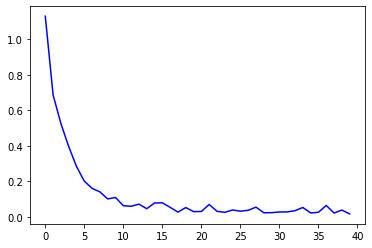

In [ ]:
# ## Add valid plot and colour
plt.plot(loss_count,"b")
# plt.savefig(r'/content/drive/My Drive/LSTM Pain No Pain (Collab)/GRU_Train_loss_'+str(num_epochs)+'_epochs1.png')

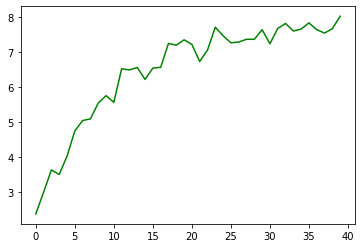

In [ ]:
# ## Add valid plot and colour
plt.plot(Test_count,"g")
# plt.savefig(r'/content/drive/My Drive/LSTM Pain No Pain (Collab)/GRU_Test_loss_'+str(num_epochs)+'_epochs1.png')

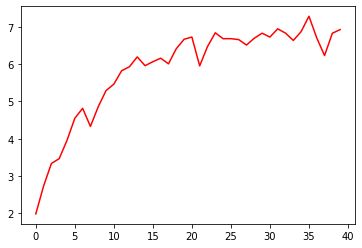

In [ ]:
## Add valid plot and colour
plt.plot(Valid_count,"r")
# plt.savefig(r'/content/drive/My Drive/LSTM Pain No Pain (Collab)/GRU_Valid_loss_'+str(num_epochs)+'_epochs1.png')

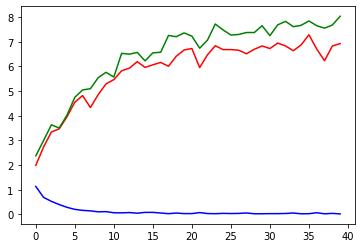

In [ ]:
## Add valid plot and colour
plt.plot(loss_count,"b")
plt.plot(Valid_count,"r")
plt.plot(Test_count,"g")
# plt.savefig(r'/content/drive/My Drive/LSTM Pain No Pain (Collab)/GRU_Train_Valid_loss_'+str(num_epochs)+'_epochs1.png')

In [ ]:
# Valid_count


In [ ]:
## Testing the model for both labels

model.eval()

test_dataset = PainDataset_Test()
test_loader = DataLoader(dataset=test_dataset,batch_size=30,shuffle=False)

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for i,data in enumerate(test_loader, 0):
        # print(data)
        features, labels = data
        features = features.reshape(-1, sequence_length, input_size).to(device)
        labels=labels.to(device)
        
        outputs = model(features)
        # print(outputs)
        _, predicted = torch.max(outputs.data, 1)
        # print('predicted',predicted)
        # print('labels',labels)
        n_samples += labels.size(0)
        n_correct += (predicted == labels.long()).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on test data: {acc} %')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Accuracy of the network on test data: 21.27296027338744 %


In [ ]:
## Testing the model for both labels

model.eval()

test_dataset = PainDataset_Train()
test_loader = DataLoader(dataset=test_dataset,batch_size=30,shuffle=False)

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for i,data in enumerate(test_loader, 0):
        # print(data)
        features, labels = data
        features = features.reshape(-1, sequence_length, input_size).to(device)
        labels=labels.to(device)
        
        outputs = model(features)
        # print(outputs)
        _, predicted = torch.max(outputs.data, 1)
        # print('predicted',predicted)
        # print('labels',labels)
        n_samples += labels.size(0)
        n_correct += (predicted == labels.long()).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on Train data: {acc} %')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Accuracy of the network on Train data: 99.42841210093405 %


In [ ]:
# PATH =r'/content/drive/My Drive/LSTM Pain No Pain (Collab)/Saved_Models/pain_model_GRU_20_epochs__90.41_test_accuracy.pth'
# torch.save(model.state_dict(), PATH)

In [ ]:
end = time.time()
print('Time taken: ',end - start)

Time taken:  172.11229467391968


In [ ]:
# import pandas as pd

In [ ]:
# # initialize list of lists 
# data = [['tom', 10], ['nick', 15], ['juli', 14]] 
  
# # Create the pandas DataFrame 
# df = pd.DataFrame(data, columns = ['Name', 'Age']) 
  
# # print dataframe. 
# df 

In [ ]:
# a='_test_'
# b='_save_'
# df.to_csv(r'/content/drive/My Drive/LSTM Pain No Pain (Collab)/Output/sample'+a+b+'.csv', index = False)